# Pairwise MLP approach

Get tracksters from a certain neighbourhood.

Train a NN to decide whether two tracksters should be joined.

Neighbourhood:
- get links from ticlNtuplizer/graph
    - figure out how these links are formed
- convert the tracksters into some latent space and predict a link between them
- later extend this using edgeconv or sageconf to add information from the neighbourhood

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


In [1]:
import uproot
import random
import numpy as np

from reco.distance import euclidian_distance
from reco.dataset import match_trackster_pairs
from reco.plotting import plot_tracksters
from reco.event import get_bary


import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

file_name = "~/data/multi/new_ntuples_14992862_991.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})
graph = uproot.open({file_name: "ticlNtuplizer/graph"})

In [2]:
eid = 0

# prepare distance points
vx = tracksters["vertices_x"].array()[eid]
vy = tracksters["vertices_y"].array()[eid]
vz = tracksters["vertices_z"].array()[eid]
ve = tracksters["vertices_energy"].array()[eid]
clouds = [np.array([vx[tid], vy[tid], vz[tid]]).T for tid in range(len(vx))]

## Candidate pairs

Compile a list of candidate pairs based on the CLUE3D graph and node distance.

Reject all nodes with above a distance threshold.

In [3]:
MAX_DISTANCE = 10   # cm

candidate_pairs = []
distances = []

inners_list = graph["linked_inners"].array()[eid]
for i, inners in enumerate(inners_list):
    for inner in inners:
        dst = euclidian_distance(clouds[i], clouds[inner])
        distances.append(dst)
        if dst <= 2*MAX_DISTANCE:
            candidate_pairs.append((i, inner))
            
print("Candidate pairs:", len(candidate_pairs))

Candidate pairs: 374


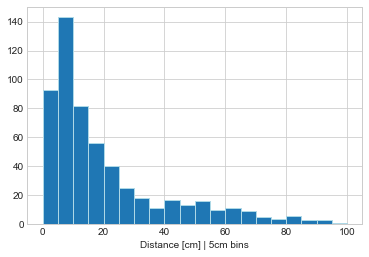

In [4]:
plt.hist(distances, bins=20, edgecolor="lightblue", range=(0, 100))
plt.xlabel("Distance [cm] | 5cm bins")
plt.show()

## Ground truth

In [5]:
gt_pairs = match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    distance_threshold=MAX_DISTANCE,
)
print("Ground truth pairs:", len(gt_pairs))

Ground truth pairs: 45


In [6]:
# sanity check
# all gold pairs are present in the candidate pairs

ab_pairs = set([(a, b) for a, b, _ in gt_pairs])
ba_pairs = set([(b, a) for a, b, _ in gt_pairs])
c_pairs = set(candidate_pairs)

matches = ab_pairs.union(ba_pairs).intersection(c_pairs)
not_matches = c_pairs - matches

positive = list(matches)
negative = random.sample(list(not_matches), k=len(matches))

print(f"positive: {len(positive)} negative: {len(not_matches)} negative selected: {len(set(negative))}")
assert len(matches) == len(gt_pairs)

positive: 45 negative: 329 negative selected: 45


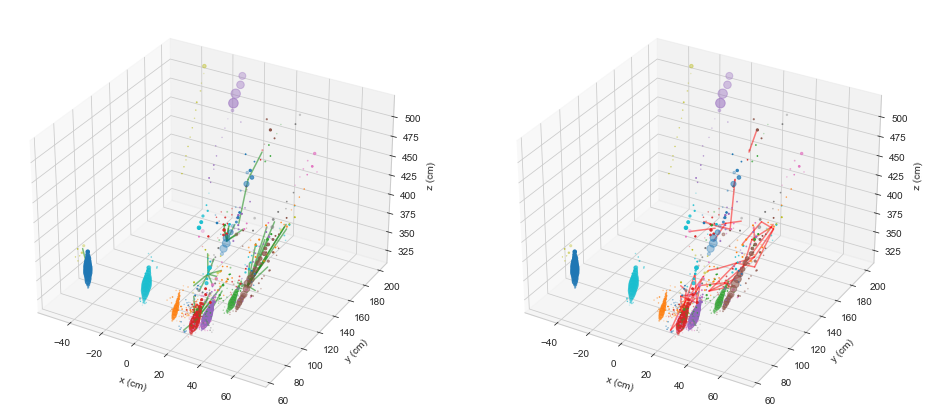

In [7]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
plot_tracksters(ax1, vx, vy, vz, ve)
plot_tracksters(ax2, vx, vy, vz, ve)
bary = get_bary(tracksters, eid)

def plot_edge(ax, edge, color):
    a, b = edge
    ca = bary[a]
    cb = bary[b]
    x = (ca[0], cb[0])
    y = (ca[1], cb[1])
    z = (ca[2], cb[2])
    ax.plot(x, y, z, c=color, alpha=0.5)

for edge in positive:
    plot_edge(ax1, edge, "green")

for edge in negative:
    plot_edge(ax2, edge, "red")

plt.show()

## MLP

In [8]:
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

from reco.data_utils import TracksterPairs

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [18]:
ds = TracksterPairs("data")
ds.data.x = torch.nn.functional.normalize(ds.data.x, p=torch.inf, dim=0)

In [19]:
class PairWiseMLP(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden=10):
        super(PairWiseMLP, self).__init__()

        self.W1 = nn.Linear(num_inputs, num_hidden)
        self.activation = nn.Sigmoid()

        self.W2 = nn.Linear(num_hidden, 1)
        self.output = nn.Sigmoid()

    def forward(self, data):
        x = self.W1(data.x)
        x = self.activation(x)
        x = self.W2(x)
        return self.output(x)

In [20]:
loss_obj = torch.nn.BCELoss()

def train(model, opt, loader):
    epoch_loss = 0
    for batch in loader:
        model.train()
        batch = batch.to(device)
        opt.zero_grad()
        z = model(batch).reshape(-1)
        loss = loss_obj(z, batch.y.type(torch.float))
        epoch_loss += loss
        loss.backward()
        opt.step()
    return float(epoch_loss)

@torch.no_grad()
def test(model, data):
    total = 0
    correct = 0
    for batch in data:
        model.eval()
        label = batch.y
        batch = batch.to(device)
        z = model(batch).reshape(-1).to("cpu")
        prediction = (z > 0.5).type(torch.int)
        total += len(prediction) 
        correct += sum(prediction == label)
    return (correct / total)

In [21]:
# balance the dataset
pos = ds[ds.data.y == 1]
neg = ds[ds.data.y == 0]
len_neg = len(neg)
len_pos = len(pos)
print(f"Positive: {len_pos}, Negative {len_neg}")
shorter = min(len_neg, len_pos)
test_n = int(shorter / 10)

Positive: 1121, Negative 1121


In [26]:
train_set = pos[:shorter - test_n] + neg[:shorter - test_n]
test_set = pos[shorter - test_n:shorter] + neg[shorter - test_n:shorter]
print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}")
train_dl = DataLoader(train_set, batch_size=16, shuffle=True)
test_dl = DataLoader(test_set, batch_size=16, shuffle=True)

Train samples: 2018, Test samples: 224


In [27]:
model = PairWiseMLP(ds.data.x.shape[1], 128)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
test_acc = test(model, test_dl)
print(f"Initial acc: {test_acc:.4f}")

for epoch in range(1, 1000):
    loss = train(model, optimizer, train_dl)
    scheduler.step()
    if epoch % 10 == 0:
        train_acc = test(model, train_dl)
        test_acc = test(model, test_dl)
        print(f'Epoch: {epoch}, loss: {loss:.4f}, train acc: {train_acc:.4f}, test acc: {test_acc:.4f}')

Initial acc: 0.5000
Epoch: 10, loss: 88.2220, train acc: 0.5000, test acc: 0.5000
Epoch: 20, loss: 88.5188, train acc: 0.5000, test acc: 0.5000
Epoch: 30, loss: 88.5047, train acc: 0.5000, test acc: 0.5000
Epoch: 40, loss: 88.2944, train acc: 0.5000, test acc: 0.5000
Epoch: 50, loss: 88.7122, train acc: 0.5000, test acc: 0.5000
Epoch: 60, loss: 88.4132, train acc: 0.5000, test acc: 0.5000
Epoch: 70, loss: 88.2836, train acc: 0.5000, test acc: 0.5000
Epoch: 80, loss: 88.2963, train acc: 0.5000, test acc: 0.5000
Epoch: 90, loss: 88.1185, train acc: 0.5015, test acc: 0.5000
Epoch: 100, loss: 88.2794, train acc: 0.5005, test acc: 0.4955
Epoch: 110, loss: 88.0237, train acc: 0.4995, test acc: 0.5000
Epoch: 120, loss: 88.1153, train acc: 0.5015, test acc: 0.5000
Epoch: 130, loss: 88.0692, train acc: 0.5000, test acc: 0.5000
Epoch: 140, loss: 87.9724, train acc: 0.5035, test acc: 0.4955
Epoch: 150, loss: 87.9874, train acc: 0.5010, test acc: 0.5312
Epoch: 160, loss: 87.8884, train acc: 0.5064

In [24]:
pred = []
lab = []
for b in test_dl:
    pred += (model(b) > 0.5).type(torch.int).tolist()
    lab += b.y.tolist()

tn, fp, fn, tp = confusion_matrix(lab, pred).ravel()
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f'Accuracy: {accuracy_score(lab, pred):.4f}')
print(f'Precision: {precision_score(lab, pred):.4f}')
print(f'Recall: {recall_score(lab, pred):.4f}')

TP: 44, TN: 81, FP: 31, FN: 68
Accuracy: 0.5580
Precision: 0.5867
Recall: 0.3929
